In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import re
import h3
import datetime

In [346]:
# building_df = pd.read_csv('OpenStreetMap/B_features.csv')

poi_df = pd.read_csv('OpenStreetMap/A_features.csv')
poi_df = poi_df[['osmid', 'amenity', 'ele', 'denomination', 'brand', 'cuisine',
                    'healthcare', 'parking', 'geometry', 'height']]

lat = []
lon = []
h3_l7 = []

for i in range(poi_df.shape[0]):
    if len(re.findall("\d+\.?\d*", poi_df.geometry[i])) < 3:
        poi_df = poi_df.drop(i, axis=0)
    else:
        latitute = float(re.findall("\d+\.?\d*", poi_df.geometry[i])[1])
        longitute = -float(re.findall("\d+\.?\d*", poi_df.geometry[i])[0])
        lat.append(latitute)
        lon.append(longitute)
        h3_l7.append(h3.geo_to_h3(latitute, longitute, resolution=7))

poi_df.drop('geometry', axis=1)
poi_df['lat'] = lat
poi_df['lon'] = lon
poi_df['h3_l7'] = h3_l7

min_lat = min(poi_df['lat'])
max_lat = max(poi_df['lat'])
min_lon = min(poi_df['lon'])
max_lon = max(poi_df['lon'])

In [347]:
ohca_df = pd.read_csv('OHCAs.csv')
h3_l7 = []

for i in range(ohca_df.shape[0]):
    h3_l7.append(h3.geo_to_h3(ohca_df.Latitude[i], ohca_df.Longitude[i], resolution=7))

ohca_df['h3_l7'] = h3_l7

if min_lat < min(ohca_df['Latitude']): min_lat = min(ohca_df['Latitude'])
if max_lat > max(ohca_df['Latitude']): max_lat = max(ohca_df['Latitude'])
if min_lon < min(ohca_df['Longitude']): min_lon = min(ohca_df['Longitude'])
if max_lon > max(ohca_df['Longitude']): max_lon = max(ohca_df['Longitude'])

ohca_df = ohca_df.drop_duplicates(subset=['ReceivedTime', 'Latitude', 'Longitude'])
ohca_df['ReceivedTime'] = pd.to_datetime(ohca_df['ReceivedTime'])
ohca_df['ReceivedTime'] = ohca_df['ReceivedTime'].apply(lambda x: x.date())

In [348]:
ems_df = pd.read_csv('EMS_Calls_For_Service.csv')
ems_df = ems_df[ems_df['IncidentTypeDescription'] == 'CARDIAC ARREST']
ems_df = ems_df.drop_duplicates(subset=['IncidentNumber'], keep='first')
ems_df = ems_df[['IncidentNumber', 'RECEIVED_TIME', 'Block', 'Street Name']]
ems_df = ems_df.dropna(subset=['Street Name'])
ems_df.loc[ems_df.Block.isna(), 'Block'] = 0
ems_df['Block'] = ems_df.Block.astype('int')
ems_df.RECEIVED_TIME = pd.to_datetime(ems_df.RECEIVED_TIME)
ems_df['Date'] = ems_df['RECEIVED_TIME'].apply(lambda x: x.date())
ems_df['Hour'] = ems_df['RECEIVED_TIME'].apply(lambda x: x.hour)
ems_df.reset_index(inplace = True)
ems_df = ems_df.drop(['index'], axis=1)

In [349]:
start_date = ems_df.loc[0, 'Date']
end_date = ems_df.loc[ems_df.shape[0]-1, 'Date']
delta = datetime.timedelta(days=1)
current_date = start_date

while (current_date <= end_date):
    today_ems = ems_df[ems_df['Date'] == current_date]
    today_ohca = ohca_df[ohca_df['ReceivedTime'] == current_date]
    
    if today_ems.shape[0] == 0 or today_ohca.shape[0] == 0:
        current_date += delta
        continue

    for i in today_ems.index:
        stna = today_ems.loc[i, 'Street Name'].split(' ')[0]
        row = np.logical_and(np.array(ohca_df['ReceivedTime'] == current_date),
                np.array(ohca_df['Incident_Location'].apply(lambda x: x.find(stna) >=0))
                )

        ind = []
        for j in today_ohca.index:
            if today_ohca.loc[j, 'Incident_Location'].find(stna) >= 0 or \
                today_ohca.loc[j, 'Incident_Location'].find(str(today_ems.loc[i, 'Block'])) >= 0:
                ind.append(j)
                continue
        ohca_df.loc[ind, 'Time'] = today_ems.loc[i, 'RECEIVED_TIME']
        ems_df = ems_df.drop(i, axis=0)
        
    current_date += delta
    
ohca_df = ohca_df.dropna(subset=['Time'])

In [350]:
ohca_df.h3_l7

0       872af636effffff
1       872af0c96ffffff
3       872af6372ffffff
4       872af0515ffffff
5       872af6266ffffff
             ...       
2698    872af6363ffffff
2699    872af0cb0ffffff
2701    872af635effffff
2703    872af6276ffffff
2705    872af636affffff
Name: h3_l7, Length: 1864, dtype: object

In [351]:
list_h3_l7 = np.unique(np.concatenate( (poi_df.h3_l7.unique(), ohca_df.h3_l7.unique())))


In [352]:
h3_l7_nei = []
for i in list_h3_l7:
    nei = []
    for j in list_h3_l7:
        if i != j and h3.h3_indexes_are_neighbors(i, j):
            nei.append(j)
    
    if len(nei) == 0: print('no neighbour')

    h3_l7_nei.append(nei)

In [353]:
cols = np.concatenate((
            poi_df.amenity.unique(),
            # np.array(['ele']),
            # poi_df.denomination.unique(),
            # poi_df.brand.unique(),
            # poi_df.cuisine.unique(),
            # poi_df.healthcare.unique(),
            # np.array(['multi-storey']),
        ))
len(cols)

h3_l7_df = pd.DataFrame(data={'id': np.unique(np.concatenate((poi_df.h3_l7.unique(), ohca_df.h3_l7.unique())))})
h3_l7_df[cols] = 0

for i in range(poi_df.shape[0]):
    h3_l7_id = poi_df.iloc[i]['h3_l7']
    h3_l7_df.loc[h3_l7_df['id'] == h3_l7_id, poi_df.iloc[i]['amenity']] += 1
#     h3_l7_df.loc[h3_l7_df['id'] == h3_l7_id, poi_df.iloc[i]['denomination']] += 1
#     h3_l7_df.loc[h3_l7_df['id'] == h3_l7_id, poi_df.iloc[i]['brand']] += 1
#     h3_l7_df.loc[h3_l7_df['id'] == h3_l7_id, poi_df.iloc[i]['cuisine']] += 1
#     h3_l7_df.loc[h3_l7_df['id'] == h3_l7_id, poi_df.iloc[i]['healthcare']] += 1

# # parking
# for i in poi_df[poi_df.parking == 'multi-storey']['h3_l7']:
#     h3_l7_df.loc[h3_l7_df['id'] == i, 'multi-storey'] += 1

In [354]:
h3_l7_df

,id,school,parking,grave_yard,college,hospital,fuel,place_of_worship,fast_food,stage,...,marketplace,car_rental,driving_school,payment_centre,dojo,gambling,bar,bicycle_parking,bbq,social_facility
0,872af0424ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,872af0425ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,872af0426ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,872af0500ffffff,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,872af0501ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,872af6373ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
133,872af6375ffffff,0,4,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
134,872af6acaffffff,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,872af6ad9ffffff,0,53,0,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [355]:
unique_h3_l7, counts = np.unique(np.array(ohca_df.h3_l7), return_counts = True)

In [356]:
h3_l7_df['ohca'] = 0
for i in range(len(unique_h3_l7)):
    h3_l7_df.loc[h3_l7_df.id == unique_h3_l7[i], 'ohca'] = counts[i]

In [357]:
h3_l7_df

,id,school,parking,grave_yard,college,hospital,fuel,place_of_worship,fast_food,stage,...,car_rental,driving_school,payment_centre,dojo,gambling,bar,bicycle_parking,bbq,social_facility,ohca
0,872af0424ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,872af0425ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,872af0426ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,872af0500ffffff,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,872af0501ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,872af6373ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
133,872af6375ffffff,0,4,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,17
134,872af6acaffffff,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
135,872af6ad9ffffff,0,53,0,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,2


In [358]:
police_record = pd.read_csv('police_record_2_hours.csv')

In [359]:
for i in range(int(10933*2/24)-1):
    police_record.iloc[12*i, 6:] = np.sum(police_record.iloc[12*i:12*i+11, 6:])
police_record = police_record.iloc[[12*i for i in range(int(10933/12)+1)]].copy()

/home/dell/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [360]:
police_h3_l7 = np.sum(police_record.iloc[:, 6:])
police_h3_l7


872af0424ffffff       4.0
872af0425ffffff       0.0
872af0426ffffff       0.0
872af0500ffffff      99.0
872af0501ffffff       4.0
                    ...  
872af6373ffffff      68.0
872af6375ffffff    1101.0
872af6acaffffff      12.0
872af6ad9ffffff     302.0
872af6adbffffff       8.0
Length: 137, dtype: float64

In [361]:
h3_l7_df['police'] = 0
for i in range(len(police_h3_l7)):
    print(police_h3_l7[i])
    h3_l7_df.loc[h3_l7_df.id == police_h3_l7[i], 'police'] = police_h3_l7[i]

4.0
0.0
0.0
99.0
4.0
34.0
48.0
67.0
1667.0
25.0
19.0
31.0
41.0
26.0
32.0
32.0
43.0
38.0
44.0
8.0
12.0
166.0
178.0
74.0
340.0
157.0
168.0
137.0
435.0
187.0
3531.0
87.0
971.0
1260.0
486.0
45.0
29.0
27.0
65.0
36.0
28.0
105.0
419.0
1146.0
1786.0
1226.0
338.0
1.0
715.0
0.0
401.0
118.0
504.0
1101.0
14.0
660.0
8.0
2993.0
1775.0
2418.0
392.0
2882.0
3388.0
3283.0
8.0
1375.0
53.0
810.0
196.0
1664.0
740.0
2166.0
448.0
98.0
96.0
1170.0
195.0
893.0
702.0
2178.0
2045.0
1381.0
9.0
1877.0
2.0
1325.0
312.0
484.0
5337.0
805.0
4369.0
311.0
2149.0
257.0
64.0
114.0
5016.0
392.0
16.0
128.0
2801.0
3812.0
1324.0
4491.0
3564.0
678.0
213.0
951.0
3046.0
3811.0
2017.0
1545.0
5269.0
3438.0
7830.0
21.0
191.0
276.0
920.0
160.0
543.0
53.0
7975.0
2833.0
4723.0
1109.0
5426.0
15851.0
1174.0
1049.0
319.0
638.0
68.0
1101.0
12.0
302.0
8.0


/tmp/ipykernel_1650436/4285346615.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(police_h3_l7[i])
/tmp/ipykernel_1650436/4285346615.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  h3_l7_df.loc[h3_l7_df.id == police_h3_l7[i], 'police'] = police_h3_l7[i]


In [362]:
h3_l7_df['police'] = np.array(police_h3_l7)

In [363]:
h3_l7_df['police']

0         4.0
1         0.0
2         0.0
3        99.0
4         4.0
        ...  
132      68.0
133    1101.0
134      12.0
135     302.0
136       8.0
Name: police, Length: 137, dtype: float64

In [364]:
h3_l7_df

,id,school,parking,grave_yard,college,hospital,fuel,place_of_worship,fast_food,stage,...,car_rental,driving_school,payment_centre,dojo,gambling,bar,bicycle_parking,bbq,social_facility,ohca
0,872af0424ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,872af0425ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,872af0426ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,872af0500ffffff,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,872af0501ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,872af6373ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
133,872af6375ffffff,0,4,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,17
134,872af6acaffffff,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
135,872af6ad9ffffff,0,53,0,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,2


In [365]:
np.where(h3_l7_df.columns == 'police')

(array([23]),)

In [368]:
# h3_l7_id1 = np.random.choice(spatial_data.shape[0]-1, 2000)
# t_pivot1 = np.random.choice(temporal_train_data.shape[0]-window_size-1, 2000)

# pivot = np.random.choice(len(ohca_occur_train), 1000)
# t_pivot2 = ohca_occur_train[pivot][:, 0] - window_size
# h3_l7_id2 = ohca_occur_train[pivot][:, 1]

# h3_l7_id = np.concatenate((h3_l7_id1.reshape(-1,1), h3_l7_id2.reshape(-1,1)), axis=0)
# t_pivot = np.concatenate((t_pivot1.reshape(-1,1), t_pivot2.reshape(-1,1)), axis=0) 

# s_fea = np.array(spatial_data[h3_l7_id]).reshape(3000, -1)

# # t_fea = torch.autograd.Variable(torch.FloatTensor(
# #             np.concatenate((temporal_train_data[t_pivot:t_pivot+window_size, [0,1,2,3,4+h3_l7_id]],
# #                             police_data[t_pivot:t_pivot+window_size, h3_l7_id].reshape((-1, 1))), axis=1)
# #                     )).cuda()
# # # X_pred = regr_net(Y)
# # features = (torch.cat( (s_fea , t_fea[-1]), dim=0 ))

# t_pivot += window_size
# h3_l7_id_ = h3_l7_id + 4

# t_fea = np.concatenate((temporal_train_data[t_pivot, 0:4].reshape(3000,4), temporal_train_data[t_pivot-1, h3_l7_id_].reshape(3000,1)), axis=1) 
# t_fea = np.concatenate((t_fea, police_data[t_pivot, h3_l7_id].reshape((-1, 1))), axis=1)

# x = np.concatenate((s_fea, t_fea), axis=1)
# y = np.array([temporal_train_data[t_pivot, 4+h3_l7_id]]).reshape((3000, -1))
# xy = np.concatenate((x, y), axis=1)

xy = h3_l7_df.iloc[:, 1:]
corr_array = np.array(xy.corr().iloc[:, -1])
np.where(np.abs(corr_array) > 0.2), corr_array[np.where(np.abs(corr_array) > 0.2)]


((array([ 0,  1,  4,  5,  6,  7,  9, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23,
         24, 28, 29, 32, 52]),),
 array([0.56548095, 0.2395146 , 0.21387975, 0.54387897, 0.62753357,
        0.6105377 , 0.47714643, 0.29987261, 0.25977723, 0.43685502,
        0.22513526, 0.20547094, 0.50983232, 0.43519265, 0.21526826,
        0.75360131, 0.3296041 , 0.32096128, 0.23321314, 0.27743068,
        0.24143836, 1.        ]))

0
1
4
5
6
7
9
12
13
14
15
17
18
19
20
22
23
24
28
29
32
52


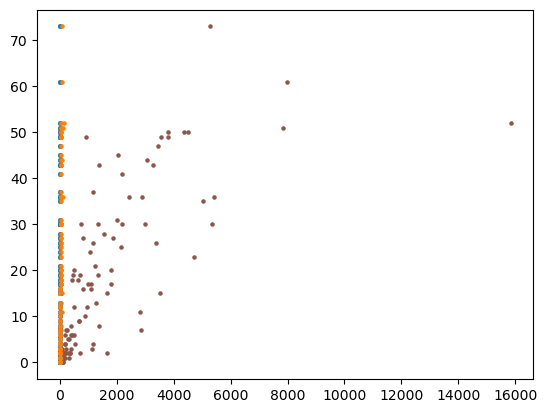

In [369]:
for i in np.where(np.abs(corr_array) > 0.2)[0]:
    print(i)
    plt.scatter(xy.iloc[:, i], xy.iloc[:, -1], s=5)
    # plt.show()

In [370]:
train_proportion = 0.6
valid_proportion = 0.2
test_proportion = 0.2

normalized_h3_l7_df = h3_l7_df.drop('id', axis=1)
normalized_h3_l7_df = (normalized_h3_l7_df - normalized_h3_l7_df.min())/(normalized_h3_l7_df.max() - normalized_h3_l7_df.min())
spatial_data = np.array(normalized_h3_l7_df).astype(np.float64)

# train_size = int(temporal_data.shape[0] * train_proportion)
# valid_size = int(temporal_data.shape[0] * valid_proportion)

# temporal_train_data = temporal_data[:train_size]
# temporal_valid_data = temporal_data[train_size:train_size+valid_size]
# temporal_test_data = temporal_data[train_size+valid_size:]

# police_train_data = police_data[:train_size]
# police_valid_data = police_data[train_size:train_size+valid_size]
# police_test_data = police_data[train_size+valid_size:]

batch_size = 100

In [371]:
spatial_data[:, 22]

array([2.52350009e-04, 0.00000000e+00, 0.00000000e+00, 6.24566273e-03,
       2.52350009e-04, 2.14497508e-03, 3.02820011e-03, 4.22686266e-03,
       1.05166866e-01, 1.57718756e-03, 1.19866254e-03, 1.95571257e-03,
       2.58658760e-03, 1.64027506e-03, 2.01880008e-03, 2.01880008e-03,
       2.71276260e-03, 2.39732509e-03, 2.77585010e-03, 5.04700019e-04,
       7.57050028e-04, 1.04725254e-02, 1.12295754e-02, 4.66847518e-03,
       2.14497508e-02, 9.90473787e-03, 1.05987004e-02, 8.64298782e-03,
       2.74430635e-02, 1.17973629e-02, 2.22761971e-01, 5.48861271e-03,
       6.12579648e-02, 7.94902530e-02, 3.06605261e-02, 2.83893761e-03,
       1.82953757e-03, 1.70336256e-03, 4.10068765e-03, 2.27115009e-03,
       1.76645007e-03, 6.62418775e-03, 2.64336635e-02, 7.22982777e-02,
       1.12674279e-01, 7.73452779e-02, 2.13235758e-02, 6.30875024e-05,
       4.51075642e-02, 0.00000000e+00, 2.52980884e-02, 7.44432528e-03,
       3.17961012e-02, 6.94593401e-02, 8.83225033e-04, 4.16377516e-02,
      

In [372]:
h3_l7_df.iloc[:, 23]

0         4.0
1         0.0
2         0.0
3        99.0
4         4.0
        ...  
132      68.0
133    1101.0
134      12.0
135     302.0
136       8.0
Name: police, Length: 137, dtype: float64

In [373]:
h3_l7_nei = []
for i in list_h3_l7:
    nei = []
    for j in list_h3_l7:
        if i != j and h3.h3_indexes_are_neighbors(i, j):
            nei.append(j)
    
    if len(nei) == 0: print('no neighbour')

    h3_l7_nei.append(nei)

In [374]:
class Regressor(nn.Module):
    def __init__(self, input_size = 2, hidden_size = 32, output_size = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.relu(self.fc1(input))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        # output = F.sigmoid(output)
        return output

class Regressor2(nn.Module):
    def __init__(self, input_size = 2, hidden_size = 32, output_size = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.relu(self.fc1(input))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        output = F.sigmoid(output)
        return output

In [375]:
window_size = 1

In [376]:
train_size = int(spatial_data.shape[0]*0.7)
h3_l7_id = np.random.choice(spatial_data.shape[0], spatial_data.shape[0])
spatial_data = spatial_data[h3_l7_id]
train_spatial_data = spatial_data[:train_size, :]
test_spatial_data = spatial_data[train_size:, :]

In [377]:
spatial_data.shape

(137, 53)

In [378]:
train_spatial_data.shape, test_spatial_data.shape, spatial_data.shape, train_size

((95, 53), (42, 53), (137, 53), 95)

In [379]:
def train_reg(spatial_data, 
                s_net, p_net,
                s_net_optim, p_net_optim,
                window_size, iter_num = 5000):

    loss_array = []
    t_fea_array = []
    s_fea_array = []

    for _ in tqdm(range(iter_num)):
        
        h3_l7_id = np.random.choice(spatial_data.shape[0]-1, window_size)

        s_fea = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id, :-1])).cuda())

        ohca = spatial_data[h3_l7_id, -1].reshape(-1,1)
        ohca = torch.autograd.Variable(torch.FloatTensor(ohca)).cuda()

        # X_pred = regr_net(Y)
        p_pred = p_net(s_fea).reshape(-1,1)

        mseloss = torch.nn.MSELoss(reduction = 'sum')
        # bceloss = torch.nn.BCELoss(reduction='none')
        loss = mseloss(p_pred, ohca)
        
        s_net_optim.zero_grad()
        p_net_optim.zero_grad()
        autograd.backward(loss)

        s_net_optim.step()
        p_net_optim.step()
        loss_array.append(loss.detach().cpu().numpy())
        # s_fea_array.append(s_fea.detach().cpu().numpy())
    
    return loss_array, t_fea_array, s_fea_array

s_net = Regressor(input_size = spatial_data.shape[1]-1, hidden_size = spatial_data.shape[1] * 2, output_size=32).cuda()
s_net_optim = optim.Adam(s_net.parameters(), lr = 1e-3, weight_decay = 1e-5)

p_net = Regressor2(input_size = 32, hidden_size = 256, output_size = 1).cuda()
p_net_optim = optim.Adam(p_net.parameters(), lr = 1e-3, weight_decay = 1e-5)

loss_array, t_fea_array, s_fea_array = train_reg(train_spatial_data, s_net, p_net,
                                                    s_net_optim, p_net_optim,
                                                    window_size, iter_num = 30000)

  0%|          | 0/30000 [00:00<?, ?it/s]

/home/dell/anaconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 30000/30000 [02:11<00:00, 228.73it/s]


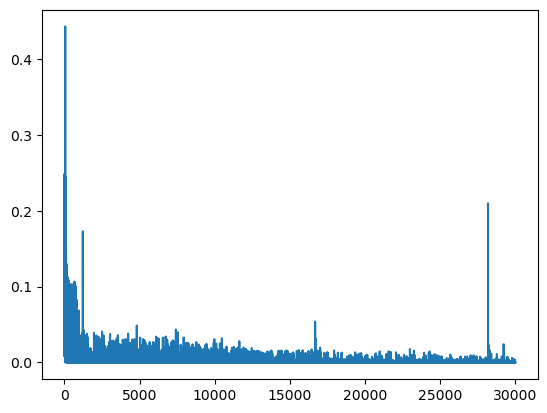

In [380]:
plt.plot(np.array(loss_array).reshape(30000))

Text(0, 0.5, 'Reality')

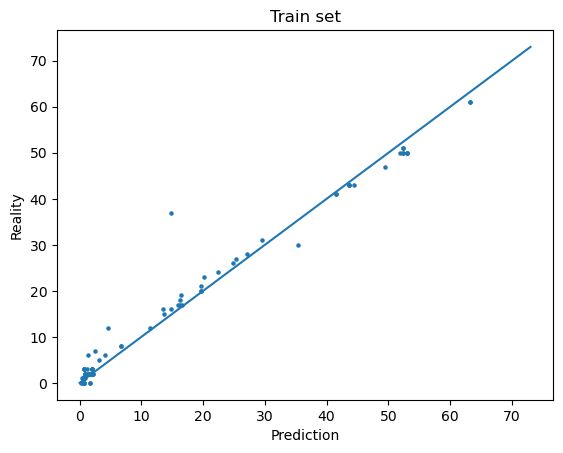

In [381]:
plt.scatter(p_net(s_net(torch.autograd.Variable(torch.FloatTensor(train_spatial_data[:, :-1])).cuda())).detach().cpu().numpy()*h3_l7_df.ohca.max(),
            train_spatial_data[:, -1]*h3_l7_df.ohca.max(),
            s = 5)
plt.plot([0, 73], [0, 73])
plt.title('Train set')
plt.xlabel('Prediction')
plt.ylabel('Reality')

Text(0, 0.5, 'Reality')

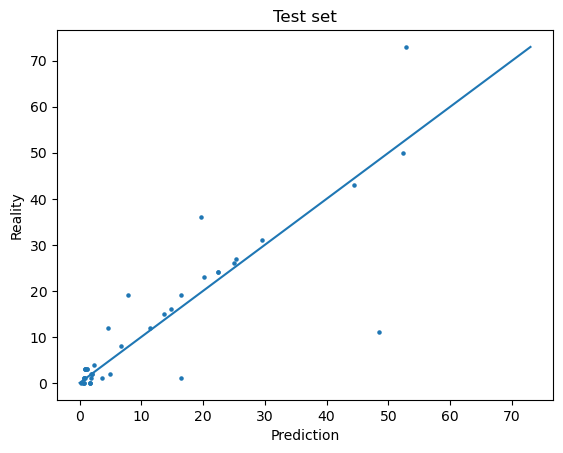

In [382]:
plt.scatter(p_net(s_net(torch.autograd.Variable(torch.FloatTensor(test_spatial_data[:, :-1])).cuda())).detach().cpu().numpy()*h3_l7_df.ohca.max(),
            test_spatial_data[:, -1]*h3_l7_df.ohca.max(),
            s = 5)
plt.plot([0, 73], [0, 73])
plt.title('Test set')
plt.xlabel('Prediction')
plt.ylabel('Reality')

In [383]:
def train_reg(spatial_data, 
                s_net, p_net,
                s_net_optim, p_net_optim,
                window_size, iter_num = 5000):

    loss_array = []
    t_fea_array = []
    s_fea_array = []

    for _ in tqdm(range(iter_num)):
        
        h3_l7_id = np.random.choice(spatial_data.shape[0]-1, window_size)

        s_fea = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id, :-1])).cuda())

        ohca = spatial_data[h3_l7_id, -1].reshape(-1,1)
        ohca = torch.autograd.Variable(torch.FloatTensor(ohca)).cuda()

        # X_pred = regr_net(Y)
        p_pred = p_net(s_fea).reshape(-1,1)

        mseloss = torch.nn.MSELoss(reduction = 'sum')
        # bceloss = torch.nn.BCELoss(reduction='none')
        loss = mseloss(p_pred, ohca)
        
        s_net_optim.zero_grad()
        p_net_optim.zero_grad()
        autograd.backward(loss)

        s_net_optim.step()
        p_net_optim.step()
        loss_array.append(loss.detach().cpu().numpy())
        # s_fea_array.append(s_fea.detach().cpu().numpy())
    
    return loss_array, t_fea_array, s_fea_array

s_net = Regressor(input_size = spatial_data.shape[1]-1, hidden_size = spatial_data.shape[1] * 2, output_size=32).cuda()
s_net_optim = optim.Adam(s_net.parameters(), lr = 1e-3, weight_decay = 1e-5)

p_net = Regressor2(input_size = 32, hidden_size = 256, output_size = 1).cuda()
p_net_optim = optim.Adam(p_net.parameters(), lr = 1e-3, weight_decay = 1e-5)

loss_array, t_fea_array, s_fea_array = train_reg(spatial_data, s_net, p_net,
                                                    s_net_optim, p_net_optim,
                                                    window_size, iter_num = 30000)

100%|██████████| 30000/30000 [02:09<00:00, 231.70it/s]


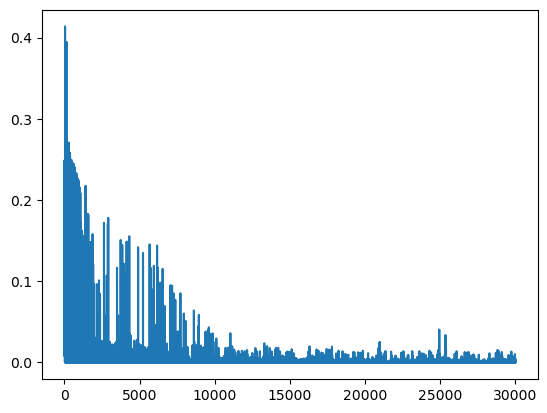

In [384]:
plt.plot(np.array(loss_array).reshape(30000))

Text(0, 0.5, 'Reality')

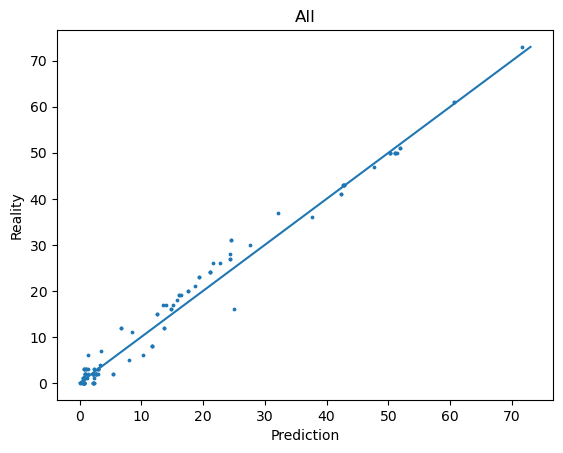

In [385]:
plt.scatter(p_net(s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[:, :-1])).cuda())).detach().cpu().numpy()*h3_l7_df.ohca.max(),
            spatial_data[:, -1]*h3_l7_df.ohca.max(),
            s = 3)
plt.plot([0, 73], [0, 73])
plt.title('All')
plt.xlabel('Prediction')
plt.ylabel('Reality')

In [386]:
p_net(s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[:, :-1])).cuda())).detach().cpu().numpy()*h3_l7_df.ohca.max()-
spatial_data[:, -1].reshape(137, 1)*h3_l7_df.ohca.max()

SyntaxError: invalid syntax (900653673.py, line 1)

Text(0, 0.5, 'Number of OHCA')

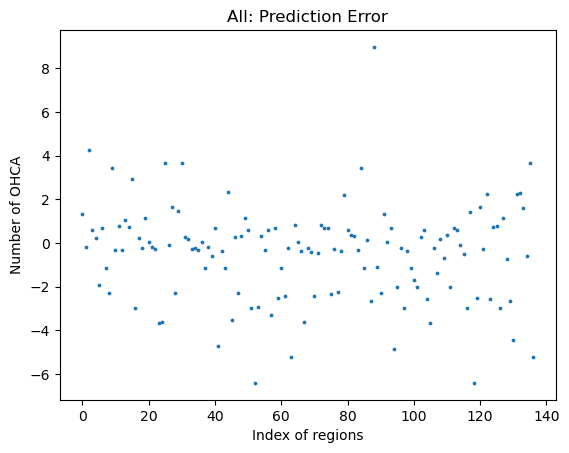

In [389]:
plt.scatter(np.arange(spatial_data.shape[0]),
            p_net(s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[:, :-1])).cuda())).detach().cpu().numpy()*h3_l7_df.ohca.max()-
            spatial_data[:, -1].reshape(137, 1)*h3_l7_df.ohca.max(),
            s = 3)
plt.title('All: Prediction Error')
plt.xlabel('Index of regions')
plt.ylabel('Number of OHCA')

/tmp/ipykernel_1650436/1781786488.py:2: RuntimeWarning: divide by zero encountered in divide
  (p_net(s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[:, :-1])).cuda())).detach().cpu().numpy()*h3_l7_df.ohca.max()-


Text(0, 0.5, 'Number of OHCA')

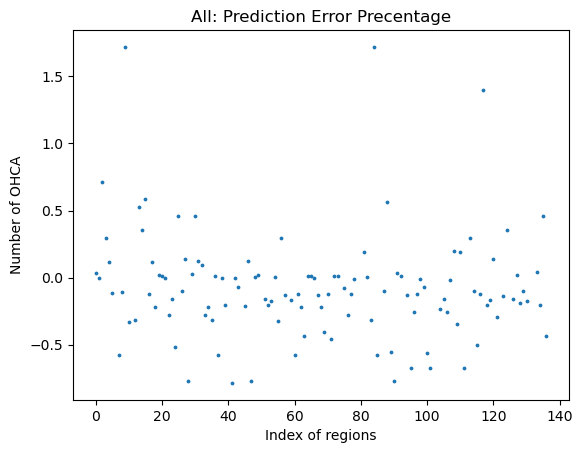

In [390]:
plt.scatter(np.arange(spatial_data.shape[0]),
            (p_net(s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[:, :-1])).cuda())).detach().cpu().numpy()*h3_l7_df.ohca.max()-
            spatial_data[:, -1].reshape(137, 1)*h3_l7_df.ohca.max())/spatial_data[:, -1].reshape(137, 1)/h3_l7_df.ohca.max(),
            s = 3)
plt.title('All: Prediction Error Precentage')
plt.xlabel('Index of regions')
plt.ylabel('Number of OHCA')

In [391]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

x = spatial_data[:, :-1]
y = spatial_data[:, -1]

lr.fit(x, y)

LinearRegression()

In [392]:
x.shape, lr.coef_.shape

((137, 52), (52,))

Text(0.5, 0, 'Index of Features')

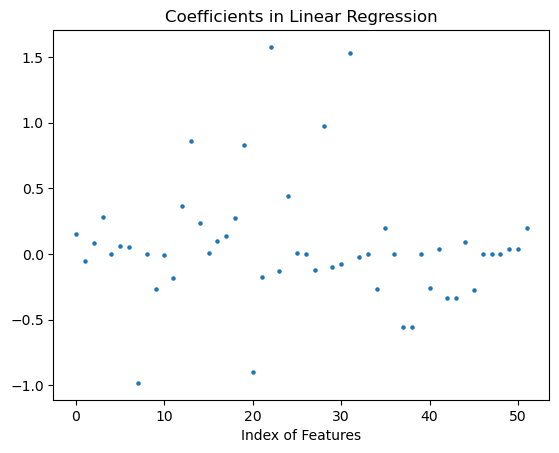

In [393]:
plt.title('Coefficients in Linear Regression')
plt.scatter(np.arange(lr.coef_.shape[0]), lr.coef_, s=5)
plt.xlabel('Index of Features')

In [394]:
np.concatenate( (np.sort(np.abs(lr.coef_))[::-1].reshape(-1, 1),
                    np.argsort(np.abs(lr.coef_))[::-1].reshape(-1, 1),
                    np.array(h3_l7_df.columns[1:-1])[np.argsort(np.abs(lr.coef_))[::-1]].reshape(-1, 1)),    
                axis=1)

array([[1.576488302926688, 22, 'police'],
       [1.5289796561985833, 31, 'clinic'],
       [0.9819965920216747, 7, 'fast_food'],
       [0.9741229447171852, 28, 'pub'],
       [0.8973884239787997, 20, 'ice_cream'],
       [0.8596971602123522, 13, 'post_office'],
       [0.8300980517531344, 19, 'bank'],
       [0.5571458479194686, 38, 'prison'],
       [0.5571458479194686, 37, 'townhall'],
       [0.4430047684942557, 24, 'shelter'],
       [0.3627303587199784, 12, 'library'],
       [0.33449331389859777, 43, 'car_rental'],
       [0.3344933138985974, 42, 'marketplace'],
       [0.28500476895329313, 3, 'college'],
       [0.27314699372020534, 45, 'payment_centre'],
       [0.27038232992596356, 9, 'restaurant'],
       [0.2700537761673996, 18, 'car_wash'],
       [0.26854495716465965, 34, 'arts_centre'],
       [0.2588615512884788, 40, 'dentist'],
       [0.23310147792226585, 14, 'pharmacy'],
       [0.1978901997327962, 35, 'kindergarten'],
       [0.19639338006214052, 51, 'social_facili

In [397]:
np.array(h3_l7_df.columns[1:-1])[np.argsort(np.abs(lr.coef_))[::-1]]

array(['police', 'clinic', 'fast_food', 'pub', 'ice_cream', 'post_office',
       'bank', 'prison', 'townhall', 'shelter', 'library', 'car_rental',
       'marketplace', 'college', 'payment_centre', 'restaurant',
       'car_wash', 'arts_centre', 'dentist', 'pharmacy', 'kindergarten',
       'social_facility', 'theatre', 'community_centre', 'school',
       'childcare', 'cafe', 'veterinary', 'cinema', 'toilets',
       'driving_school', 'grave_yard', 'animal_shelter', 'fuel',
       'place_of_worship', 'parking', 'studio', 'bicycle_parking', 'bbq',
       'exhibition_centre', 'fire_station', 'ranger_station',
       'university', 'shower', 'stage', 'hospital', 'nightclub',
       'gambling', 'bar', 'dojo', 'doctors', 'bus_station'], dtype=object)

In [396]:
np.concatenate( (np.sort(lr.coef_)[::-1].reshape(-1, 1),
                    np.argsort(lr.coef_)[::-1].reshape(-1, 1),
                    np.array(h3_l7_df.columns[1:-1])[np.argsort(lr.coef_)[::-1]].reshape(-1, 1)),    
                axis=1)

array([[1.576488302926688, 22, 'police'],
       [1.5289796561985833, 31, 'clinic'],
       [0.9741229447171852, 28, 'pub'],
       [0.8596971602123522, 13, 'post_office'],
       [0.8300980517531344, 19, 'bank'],
       [0.4430047684942557, 24, 'shelter'],
       [0.3627303587199784, 12, 'library'],
       [0.28500476895329313, 3, 'college'],
       [0.2700537761673996, 18, 'car_wash'],
       [0.23310147792226585, 14, 'pharmacy'],
       [0.1978901997327962, 35, 'kindergarten'],
       [0.19639338006214052, 51, 'social_facility'],
       [0.1543680586511519, 0, 'school'],
       [0.13329481908778484, 17, 'childcare'],
       [0.10146017783151776, 16, 'toilets'],
       [0.08936182853759819, 44, 'driving_school'],
       [0.0849724704973064, 2, 'grave_yard'],
       [0.05886010407721959, 5, 'fuel'],
       [0.052261260154223665, 6, 'place_of_worship'],
       [0.03588116980459493, 41, 'studio'],
       [0.03588116980459365, 49, 'bicycle_parking'],
       [0.035881169804593424, 50, 'bb

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [02:46<00:00, 119.86it/s]


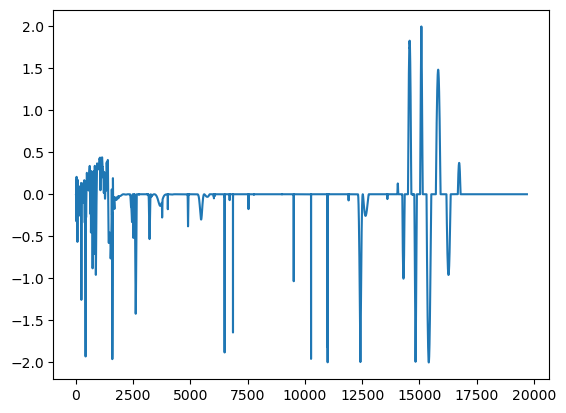

In [195]:
# mutual information

def mlp(dim, hidden_dim, output_dim, layers, activation):
    """Create a mlp from the configurations."""
    activation = {
        'relu': nn.ReLU
    }[activation]

    seq = [nn.Linear(dim, hidden_dim), activation()]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation()]
    seq += [nn.Linear(hidden_dim, output_dim)]

    return nn.Sequential(*seq)

class SeparableCritic(nn.Module):
    """Separable critic. where the output value is g(x) h(y). """

    def __init__(self, x_dim, y_dim, hidden_dim, embed_dim, layers, activation, **extra_kwargs):
        super(SeparableCritic, self).__init__()
        self._g = mlp(x_dim, hidden_dim, embed_dim, layers, activation)
        self._h = mlp(y_dim, hidden_dim, embed_dim, layers, activation)

    def forward(self, x, y):
        scores = torch.matmul(self._h(y), self._g(x).t())
        return scores


class ConcatCritic(nn.Module):
    """Concat critic, where we concat the inputs and use one MLP to output the value."""

    def __init__(self, x_dim, y_dim, hidden_dim, layers, activation, **extra_kwargs):
        super(ConcatCritic, self).__init__()
        # output is scalar score
        self._f = mlp(x_dim+y_dim, hidden_dim, 1, layers, activation)

    def forward(self, x, y):
        batch_size = x.size(0)
        # Tile all possible combinations of x and y
        x_tiled = torch.stack([x] * batch_size, dim=0)
        y_tiled = torch.stack([y] * batch_size, dim=1)
        # xy is [batch_size * batch_size, x_dim + y_dim]
        xy_pairs = torch.reshape(torch.cat((x_tiled, y_tiled), dim=2), [
                                 batch_size * batch_size, -1])
        # Compute scores for each x_i, y_j pair.
        scores = self._f(xy_pairs)
        return torch.reshape(scores, [batch_size, batch_size]).t()

data_params = {
    'x_dim': 204,
    'y_dim': 1,
    'batch_size': 64,
    'cubic': None
}

critic_params = {
    'x_dim': 204,
    'y_dim': 1,
    'layers': 3,
    'embed_dim': 512,
    'hidden_dim': 512,
    'activation': 'relu',
}

opt_params = {
    'iterations': 20000,
    'learning_rate': 2e-4,
}

estimator = 'smile'
clip = 5.0

CRITICS = {
    'separable': SeparableCritic,
    'concat': ConcatCritic,
}
critic = CRITICS['separable'](rho=None, **critic_params).cuda()
opt_crit = optim.Adam(critic.parameters(), lr=opt_params['learning_rate'])

estimates = []

"""Main training loop that estimates time-varying MI."""
# Ground truth rho is only used by conditional critic
window_size=100
for i in tqdm(range(opt_params['iterations'])):
    # h3_l7_id = np.random.choice(spatial_data.shape[0], window_size)

    x = torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id, :-1])).cuda()

    ohca = spatial_data[h3_l7_id, -1].reshape(-1,1)
    y = torch.autograd.Variable(torch.FloatTensor(ohca)).cuda()
    
    x, y = x.cuda(), y.cuda()
    scores = critic(x, y)
    if clip is not None:
        f_ = torch.clamp(scores, -clip, clip)
    else:
        f_ = scores

    if f_.isnan().any():
        print(i, 'f_')
        break
    
    batch_size = f_.size(0)
    logsumexp = torch.logsumexp(
        f_ - torch.diag(np.inf * torch.ones(batch_size).to('cuda')), dim=(0, 1))
    try:
        if len((0, 1)) == 1:
            num_elem = batch_size - 1.
        else:
            num_elem = batch_size * (batch_size - 1.)
    except ValueError:
        num_elem = batch_size - 1
    z = logsumexp - torch.log(torch.tensor(num_elem)).to('cuda')
    dv = scores.diag().mean() - z
    """Lower bound on Jensen-Shannon divergence from Nowozin et al. (2016)."""
    f_diag = scores.diag()
    first_term = -F.softplus(-f_diag).mean()
    n = scores.size(0)
    if n == 1: n = 2
    second_term = (torch.sum(F.softplus(scores)) -
                torch.sum(F.softplus(f_diag))) / (n * (n - 1.))
    js = first_term - second_term


    with torch.no_grad():
        dv_js = dv - js

    if dv.isnan():
        print(i, 'dv', num_elem)
        break

    mi = js + dv_js
    loss = -mi

    loss.backward()
    opt_crit.step()

    mi = mi.detach().cpu().numpy()
    estimates.append(mi)

mis =  np.array(estimates)
plt.plot(mis[np.abs(mis)<2])

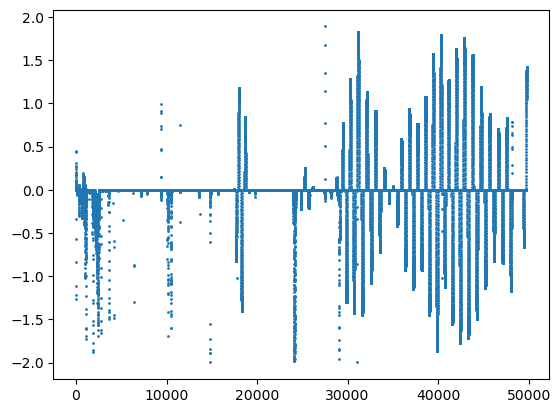

In [ ]:
plt.scatter(np.arange(len(mis[np.abs(mis)<2])), mis[np.abs(mis)<2], s = 1)

In [73]:
h3_l7_id1 = np.random.choice(spatial_data.shape[0]-1, 2000)
t_pivot1 = np.random.choice(temporal_train_data.shape[0]-window_size-1, 2000)

pivot = np.random.choice(len(ohca_occur_train), 1000)
t_pivot2 = ohca_occur_train[pivot][:, 0] - window_size
h3_l7_id2 = ohca_occur_train[pivot][:, 1]

h3_l7_id = np.concatenate((h3_l7_id1.reshape(-1,1), h3_l7_id2.reshape(-1,1)), axis=0)
t_pivot = np.concatenate((t_pivot1.reshape(-1,1), t_pivot2.reshape(-1,1)), axis=0) 

s_fea = np.array(spatial_data[h3_l7_id]).reshape(3000, -1)

# t_fea = torch.autograd.Variable(torch.FloatTensor(
#             np.concatenate((temporal_train_data[t_pivot:t_pivot+window_size, [0,1,2,3,4+h3_l7_id]],
#                             police_data[t_pivot:t_pivot+window_size, h3_l7_id].reshape((-1, 1))), axis=1)
#                     )).cuda()
# # X_pred = regr_net(Y)
# features = (torch.cat( (s_fea , t_fea[-1]), dim=0 ))

t_pivot += window_size
h3_l7_id_ = h3_l7_id + 4

t_fea = np.concatenate((temporal_train_data[t_pivot, 0:4].reshape(3000,4), temporal_train_data[t_pivot-1, h3_l7_id_].reshape(3000,1)), axis=1) 
t_fea = np.concatenate((t_fea, police_data[t_pivot, h3_l7_id].reshape((-1, 1))), axis=1)

x = np.concatenate((s_fea, t_fea), axis=1)
y = np.array([temporal_train_data[t_pivot, 4+h3_l7_id]]).reshape((3000, -1))
xy = np.concatenate((x, y), axis=1)

xy = pd.DataFrame(xy)
corr_array = np.array(xy.corr().loc[:, 210])
np.where(np.abs(corr_array) > 0.2), corr_array[np.where(np.abs(corr_array) > 0.2)]
for i in np.where(np.abs(corr_array) > 0.2)[0]:
    print(i)
    plt.scatter(xy.loc[:, i], xy.loc[:, 210], s=5)
    plt.show()

In [90]:
ohca_occur_test = ohca_occur_train

In [91]:
p_pred_ls = []

correct = 0

for i in range(len(ohca_occur_test)):
    t_pivot = ohca_occur_test[i][0] - window_size
    h3_l7_id = ohca_occur_test[i][1]

    s_fea = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id])).cuda())

    h_state = None
    # t_fea, h_state = t_net(torch.autograd.Variable(torch.FloatTensor(temporal_data[t_pivot:t_pivot+window_size, [0,1,2,3,4+h3_l7_id]])).cuda(), h_state)
    t_fea, h_state = t_net(torch.autograd.Variable(torch.FloatTensor(
                            np.concatenate(
                                (temporal_data[t_pivot:t_pivot+window_size, [0,1,2,3,4+h3_l7_id]], police_data[t_pivot:t_pivot+window_size, h3_l7_id].reshape((-1, 1))), axis=1)
                            )).cuda(), h_state)

    p_pred = p_net(torch.cat( (s_fea , t_fea[-1]), dim=0 ))
    p_pred_ls.append(p_pred.detach().cpu().float().item())
    if p_pred > 0.501851 and temporal_data[t_pivot+window_size, 4+h3_l7_id] >= 1:
        correct +=1

    if i % 20 == 0:
        print(s_fea, t_fea, p_pred)

correct/len(ohca_occur_test)

/home/dell/anaconda3/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601,
        0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601,
        0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601,
        0.4601, 0.4601, 0.4601, 0.4601, 0.4601], device='cuda:0',
       grad_fn=<SigmoidBackward0>) tensor([[-4.3206,  1.9626,  2.5399,  ...,  2.5870, -3.6538, -2.1828],
        [-5.1360,  2.1629,  2.3719,  ...,  2.3946, -7.2491, -2.4680],
        [-5.4491,  2.3547,  2.5648,  ...,  2.5879, -7.4173, -2.6785],
        ...,
        [-5.4565,  2.3567,  2.5655,  ...,  2.5885, -7.4360, -2.6815],
        [-5.4564,  2.3567,  2.5655,  ...,  2.5885, -7.4360, -2.6815],
        [-5.4565,  2.3567,  2.5655,  ...,  2.5885, -7.4360, -2.6815]],
       device='cuda:0', grad_fn=<AddmmBackward0>) tensor([0.5052], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601, 0.4601,
        0.4601, 0.4601, 0.4601, 0

1.0

[0.5018509030342102, 0.5018510222434998, 0.5018510818481445, 0.5018510222434998, 0.5018510222434998, 0.5018509030342102, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018509030342102, 0.5018508434295654, 0.501850962638855, 0.501850962638855, 0.501850962638855, 0.5018510222434998, 0.5018510818481445, 0.501850962638855, 0.5018509030342102, 0.5018511414527893, 0.5018509030342102, 0.5018510818481445, 0.5018510222434998, 0.5018510222434998, 0.5018510222434998, 0.5018509030342102, 0.5018508434295654, 0.5018508434295654, 0.501850962638855, 0.501850962638855, 0.5018510818481445, 0.501850962638855, 0.501850962638855, 0.5018510222434998, 0.5018510818481445, 0.5018509030342102, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.501850962638855, 0.5018509030342102, 0.5018509030342102, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018508434

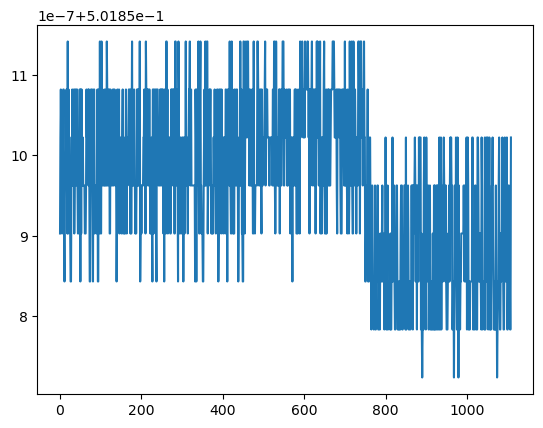

In [19]:
print(p_pred_ls)
plt.plot(p_pred_ls)

In [20]:
p_pred = []
correct = 0
occurred = 0
for i in range(600):
    h3_l7_id = np.random.randint(spatial_data.shape[0]-1)
    t_pivot = np.random.randint(temporal_test_data.shape[0]-window_size-1)

    s_fea = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id])).cuda())

    h_state = None
    # t_fea, h_state = t_net(torch.autograd.Variable(torch.FloatTensor(temporal_test_data[t_pivot:t_pivot+window_size, [0,1,2,3,4+h3_l7_id]])).cuda(), h_state)
    t_fea, h_state = t_net(torch.autograd.Variable(torch.FloatTensor(
                            np.concatenate(
                                (temporal_test_data[t_pivot:t_pivot+window_size, [0,1,2,3,4+h3_l7_id]], police_test_data[t_pivot:t_pivot+window_size, h3_l7_id].reshape((-1, 1))), axis=1)
                            )).cuda(), h_state)
    p_pred = p_net(torch.cat( (s_fea , t_fea[-1]), dim=0 ))
    p_pred_ls.append(p_pred.detach().cpu().float().item())

    if p_pred < 0.4 and temporal_test_data[t_pivot+window_size, 4+h3_l7_id] == 0:
        correct += 1
    elif temporal_test_data[t_pivot+window_size, 4+h3_l7_id] >= 1:
        occurred += 1

    # print(t_pivot, h3_l7_id, temporal_test_data[t_pivot+window_size, 4+h3_l7_id], p_pred)
correct/(600-occurred)

0.0

[0.5018509030342102, 0.5018510222434998, 0.5018510818481445, 0.5018510222434998, 0.5018510222434998, 0.5018509030342102, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018509030342102, 0.5018508434295654, 0.501850962638855, 0.501850962638855, 0.501850962638855, 0.5018510222434998, 0.5018510818481445, 0.501850962638855, 0.5018509030342102, 0.5018511414527893, 0.5018509030342102, 0.5018510818481445, 0.5018510222434998, 0.5018510222434998, 0.5018510222434998, 0.5018509030342102, 0.5018508434295654, 0.5018508434295654, 0.501850962638855, 0.501850962638855, 0.5018510818481445, 0.501850962638855, 0.501850962638855, 0.5018510222434998, 0.5018510818481445, 0.5018509030342102, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.501850962638855, 0.5018509030342102, 0.5018509030342102, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018508434

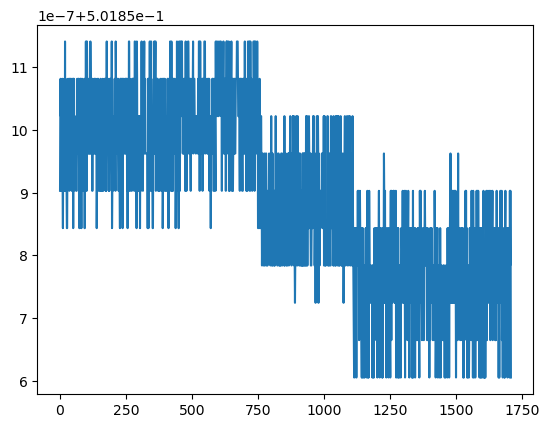

In [21]:
print(p_pred_ls)
plt.plot(p_pred_ls)

[0.5018509030342102, 0.5018510222434998, 0.5018510818481445, 0.5018510222434998, 0.5018510222434998, 0.5018509030342102, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018509030342102, 0.5018508434295654, 0.501850962638855, 0.501850962638855, 0.501850962638855, 0.5018510222434998, 0.5018510818481445, 0.501850962638855, 0.5018509030342102, 0.5018511414527893, 0.5018509030342102, 0.5018510818481445, 0.5018510222434998, 0.5018510222434998, 0.5018510222434998, 0.5018509030342102, 0.5018508434295654, 0.5018508434295654, 0.501850962638855, 0.501850962638855, 0.5018510818481445, 0.501850962638855, 0.501850962638855, 0.5018510222434998, 0.5018510818481445, 0.5018509030342102, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.501850962638855, 0.5018509030342102, 0.5018509030342102, 0.5018510222434998, 0.501850962638855, 0.5018510818481445, 0.5018510818481445, 0.5018508434

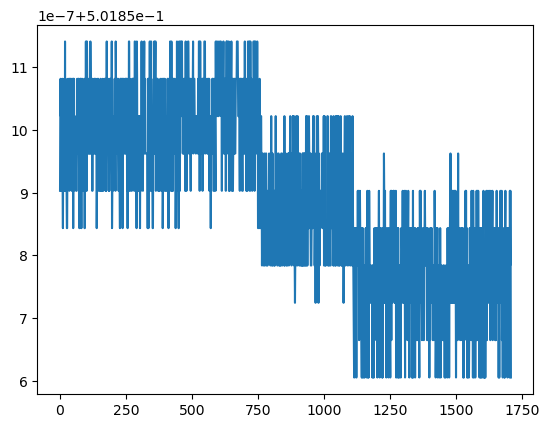

In [22]:
print(p_pred_ls)
plt.plot(p_pred_ls)